## Imports

In [14]:
from pathlib import Path
import json
import hashlib

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.model_selection import GridSearchCV

import torch
import numpy as np

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Setup

In [2]:
ROCLICO_ROOT = Path("../dataset-creation/RoCliCo")
CSV_PATH = ROCLICO_ROOT / "rocloco_combined.csv"
TRAIN_DIR = ROCLICO_ROOT / "Train"
TEST_DIR  = ROCLICO_ROOT / "Test"

def normalize_ws(s: str) -> str:
    return " ".join((s or "").split())

def read_json_list(path: Path):
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"{path} is not a JSON list")
    return data

def load_from_json_dirs() -> pd.DataFrame:
    rows = []
    for split_name, split_dir in [("train", TRAIN_DIR), ("test", TEST_DIR)]:
        for fp in sorted(split_dir.glob("*.json")):
            src = fp.stem
            items = read_json_list(fp)
            for i, obj in enumerate(items):
                rows.append({
                    "split": split_name,
                    "source_file": src,
                    "idx_in_file": i,
                    "title": normalize_ws(obj.get("title", "")),
                    "content": normalize_ws(obj.get("content", "")),
                    "category": normalize_ws(obj.get("category", "")).lower(),
                })
    return pd.DataFrame(rows)

if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH, encoding="utf-8")
    print("Loaded CSV:", CSV_PATH, "| rows:", len(df))
else:
    df = load_from_json_dirs()
    print("Loaded from JSON dirs | rows:", len(df))

df.head(3)

Loaded CSV: ..\dataset-creation\RoCliCo\rocloco_combined.csv | rows: 8313


,split,source_file,idx_in_file,title,content,category,title_len,content_len,text_len,title_md5,content_md5,pair_md5
0,train,cancan,0,Cât a ajuns să coste un kilogram de cozonac în...,Cozonacul este alimentul „vedetă” care nu lips...,clickbait,131,1775,1906,03f12eb1c86c4d523510dfc1684cb861,d902eefe645f5553f681c9f288c6e88c,39337df7970f1ca7f81bba252add9a9d
1,train,cancan,1,Doliu în lumea artistică. Compozitorul Angelo ...,Este doliu în lumea artistică. Compozitorul An...,nonclickbait,78,1969,2047,23cfe780420c123debc4fe8d28f65a47,87138639b9298cb9942f7b9157ff3892,c1fa935517912cd72ca7221442e75226
2,train,cancan,2,Imagini rare cu Nicolae Ceaușescu! Cum control...,Nicolae Ceaușescu nu a fost doar președintele ...,clickbait,131,1855,1986,7dfc7e56a757d4821941fab9eecfc695,258f43d9f15d01c91893f44a03bf29c8,6508d2536444c80662350a43b4d96219


In [3]:
print("Splits:", df["split"].value_counts(dropna=False).to_dict() if "split" in df.columns else "no split column")
print("Categories:", df["category"].value_counts(dropna=False).to_dict())
unexpected = sorted(set(df["category"]) - {"clickbait","nonclickbait"})
print("Unexpected categories:", unexpected)

# Drop empty rows (defensive)
df["title"] = df["title"].fillna("").astype(str)
df["content"] = df["content"].fillna("").astype(str)
df["text"] = (df["title"].str.strip() + " \n\n " + df["content"].str.strip()).str.strip()

df = df[df["text"].str.len() > 0].copy()
df = df[df["category"].isin(["clickbait","nonclickbait"])].copy()

df["y"] = (df["category"] == "clickbait").astype(int)
print("Rows after cleaning:", len(df))
df[["split","source_file","category","y","text"]].head(2)

Splits: {'train': 6806, 'test': 1507}
Categories: {'nonclickbait': 4593, 'clickbait': 3720}
Unexpected categories: []
Rows after cleaning: 8313


,split,source_file,category,y,text
0,train,cancan,clickbait,1,Cât a ajuns să coste un kilogram de cozonac în...
1,train,cancan,nonclickbait,0,Doliu în lumea artistică. Compozitorul Angelo ...


## Train/Test Split

In [4]:
if "split" in df.columns and set(df["split"].unique()) >= {"train","test"}:
    train_df = df[df["split"] == "train"].copy()
    test_df = df[df["split"] == "test"].copy()
else:
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["y"]
    )

print("Train:", len(train_df), "Test:", len(test_df))
print("Train label distribution:", train_df["category"].value_counts().to_dict())
print("Test  label distribution:", test_df["category"].value_counts().to_dict())

Train: 6806 Test: 1507
Train label distribution: {'nonclickbait': 3527, 'clickbait': 3279}
Test  label distribution: {'nonclickbait': 1066, 'clickbait': 441}


## TF-IDF + Linear SVM Classifier

In [8]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key: str):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key].astype(str).values

word_tfidf = Pipeline([
    ("select", TextSelector("text")),
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
    ))
])

char_tfidf = Pipeline([
    ("select", TextSelector("text")),
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        analyzer="char_wb",
        ngram_range=(3,5),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
    ))
])

features = FeatureUnion([
    ("word", word_tfidf),
    ("char", char_tfidf),
])

base_clf = LinearSVC()
clf = CalibratedClassifierCV(base_clf, method="sigmoid", cv=3)

model = Pipeline([
    ("features", features),
    ("clf", clf),
])

model

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.95,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  sublinear_tf=True))])),
                                                ('char',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_df=0.95,
                                                                                  min_df=2,
                                                                                  ngram_range=(3,
                                                                                               5),
                                                                                  sublinear_tf=True))]))])),
                ('clf', CalibratedClassifierCV(cv=3, estimator=LinearSVC()))])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'clf__estimator__C': 0.1, 'clf__estimator__class_weight': 'balanced', 'features__char__tfidf__ngram_range': (3, 5), 'features__word__tfidf__min_df': 1, 'features__word__tfidf__ngram_range': (1, 2)}
Best CV score: 0.5655093470568974
              precision    recall  f1-score   support

nonclickbait       0.73      0.95      0.83      1066
   clickbait       0.57      0.16      0.25       441

    accuracy                           0.72      1507
   macro avg       0.65      0.56      0.54      1507
weighted avg       0.69      0.72      0.66      1507



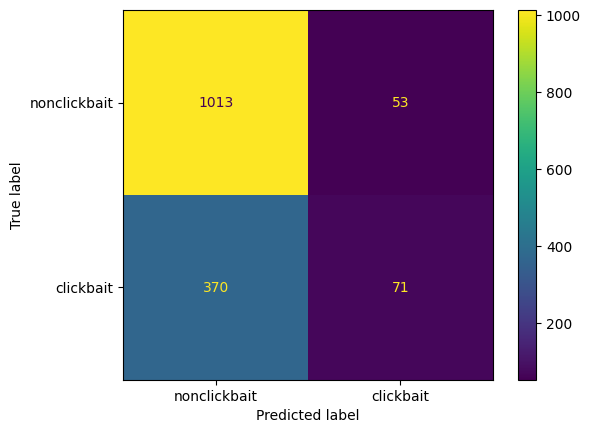

In [10]:
X_train = train_df
y_train = train_df["y"].values
X_test = test_df
y_test = test_df["y"].values

param_grid = {
    "features__word__tfidf__ngram_range": [(1,1), (1,2)],
    "features__char__tfidf__ngram_range": [(3,5), (4,6)],
    "features__word__tfidf__min_df": [1, 2, 5],

    "clf__estimator__C": [0.1, 1.0, 5.0],
    "clf__estimator__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["nonclickbait","clickbait"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["nonclickbait","clickbait"])
disp.plot()
plt.show()

## Check on clickbaits from test

In [12]:
proba = best_model.predict_proba(X_test)[:, 1]
tmp = test_df.copy()
tmp["p_clickbait"] = proba
tmp["pred"] = (proba >= 0.5).astype(int)
tmp["pred_label"] = tmp["pred"].map({0:"nonclickbait", 1:"clickbait"})

print("Highest-confidence clickbait predictions:")
display(tmp.sort_values("p_clickbait", ascending=False)[["source_file","category","pred_label","p_clickbait","title"]].head(10))

print("\nLowest-confidence (most nonclickbait) predictions:")
display(tmp.sort_values("p_clickbait", ascending=True)[["source_file","category","pred_label","p_clickbait","title"]].head(10))

Highest-confidence clickbait predictions:


,source_file,category,pred_label,p_clickbait,title
7136,digi,clickbait,clickbait,0.714399,Echinocțiul de primăvară are loc astăzi. Când ...
6875,digi,nonclickbait,clickbait,0.703101,Se modifică legislația rutieră: Șoferii pot fi...
7780,libertatea,nonclickbait,clickbait,0.697130,INVESTIGAȚIE. Libertatea este în posesia unor ...
7604,libertatea,nonclickbait,clickbait,0.668523,Gazele și electricitatea s-au ieftinit pe burs...
6881,digi,clickbait,clickbait,0.663639,De ce statul e cel mai bun angajator din Român...
8078,viva,clickbait,clickbait,0.663529,Cum se înțeleg Doina Teodoru și Cătălin Scărlă...
7790,libertatea,clickbait,clickbait,0.657940,Plafonare la un preț mai mare. Ce înseamnă îng...
8221,viva,nonclickbait,clickbait,0.656427,Gestul secret prin care Meghan Markle îl atenț...
7085,digi,nonclickbait,clickbait,0.651127,Prețul motorinei scade la minimul ultimelor 9 ...
7881,libertatea,nonclickbait,clickbait,0.649919,Un șofer român de TIR care le-a spus polițiști...



Lowest-confidence (most nonclickbait) predictions:


,source_file,category,pred_label,p_clickbait,title
7560,libertatea,nonclickbait,nonclickbait,0.107808,"Război în Ucraina, ziua 401 | Kievul și Moscov..."
7784,libertatea,nonclickbait,nonclickbait,0.109426,"Război în Ucraina, ziua 398 | Luptele s-au int..."
7388,libertatea,nonclickbait,nonclickbait,0.120853,"Război în Ucraina, ziua 404 | Orașele Bahmut, ..."
7127,digi,nonclickbait,nonclickbait,0.126844,Accident pe DN2 cu 2 mașini și 3 TIR-uri. Trei...
6892,digi,nonclickbait,nonclickbait,0.127100,Foto Accident cu opt răniţi pe un drum acoperi...
7468,libertatea,nonclickbait,nonclickbait,0.130231,"LIVETEXT Război în Ucraina, ziua 403 | Atac as..."
7321,libertatea,nonclickbait,nonclickbait,0.131400,"Război în Ucraina, ziua 405 | Portul Odesa, at..."
7849,libertatea,nonclickbait,nonclickbait,0.131784,"Război în Ucraina, ziua 397 | 41 de atacuri ru..."
7123,digi,nonclickbait,nonclickbait,0.131842,VIDEO Un incendiu puternic a izbucnit la un bl...
7420,libertatea,nonclickbait,nonclickbait,0.133648,Accident grav în Vaslui. Un șofer a adormit la...


## Save model

In [13]:
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "rocloco_clickbait_tfidf_linsvc_calibrated.joblib"
joblib.dump(best_model, model_path)
model_path

WindowsPath('models/rocloco_clickbait_tfidf_linsvc_calibrated.joblib')

## Transformers

In [15]:
def build_text(df):
    title = df["title"].fillna("").astype(str)
    content = df["content"].fillna("").astype(str)
    return (title + " [SEP] " + content).str.strip()

train_df = train_df.copy()
test_df = test_df.copy()

train_df["text"] = build_text(train_df)
test_df["text"] = build_text(test_df)

train_df["label"] = train_df["y"].astype(int)
test_df["label"] = test_df["y"].astype(int)

train_df[["text","label"]].head()

,text,label
0,Cât a ajuns să coste un kilogram de cozonac în...,1
1,Doliu în lumea artistică. Compozitorul Angelo ...,0
2,Imagini rare cu Nicolae Ceaușescu! Cum control...,1
3,Tragedie în Galați! Un polițist de 21 de ani ș...,0
4,Prețurile au explodat! Câți lei costă 1 kg de ...,1


In [16]:
MODEL_NAME = "readerbench/RoBERT-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

C:\Users\alex_\.conda\envs\test_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alex_\.cache\huggingface\hub\models--readerbench--RoBERT-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\alex_\.conda\envs\test_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `r

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/463M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
train_ds = Dataset.from_pandas(
    train_df[["text", "label"]].reset_index(drop=True)
)

test_ds = Dataset.from_pandas(
    test_df[["text", "label"]].reset_index(drop=True)
)

train_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 6806
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1507
 }))

In [18]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=512,
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/6806 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [20]:
training_args = TrainingArguments(
    output_dir="./rocloco_roberta_clickbait",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=100,
    report_to="none",
)

C:\Users\alex_\.conda\envs\test_env\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.418500,0.227521,0.930989,0.937662,0.818594,0.874092
2,0.359600,0.212864,0.938952,0.914489,0.873016,0.893271
3,0.277400,0.271322,0.930325,0.903846,0.852608,0.877480


TrainOutput(global_step=2553, training_loss=0.37435420858500473, metrics={'train_runtime': 2916.0559, 'train_samples_per_second': 7.002, 'train_steps_per_second': 0.875, 'total_flos': 5372201528340480.0, 'train_loss': 0.37435420858500473, 'epoch': 3.0})

In [23]:
trainer.evaluate()

{'eval_loss': 0.21286433935165405,
 'eval_accuracy': 0.9389515593895156,
 'eval_precision': 0.9144893111638955,
 'eval_recall': 0.873015873015873,
 'eval_f1': 0.8932714617169374,
 'eval_runtime': 66.4376,
 'eval_samples_per_second': 22.683,
 'eval_steps_per_second': 2.845,
 'epoch': 3.0}

In [24]:
import numpy as np
from sklearn.metrics import f1_score

preds = trainer.predict(test_ds)
logits = preds.predictions
labels = preds.label_ids

probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()

thresholds = np.linspace(0.1, 0.9, 81)
scores = []

for t in thresholds:
    p = (probs >= t).astype(int)
    scores.append(f1_score(labels, p))

best_t = thresholds[np.argmax(scores)]
best_f1 = max(scores)

best_t, best_f1

(0.89, 0.9093078758949881)

In [26]:
MODEL_DIR = Path("models/rocloco_roberta_clickbait")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

trainer.save_model(str(MODEL_DIR))
tokenizer.save_pretrained(str(MODEL_DIR))

meta = {"threshold": best_t if "best_t" in globals() else 0.5,
        "label_map": {"0": "nonclickbait", "1": "clickbait"},
        "model_name": MODEL_NAME}
with (MODEL_DIR / "meta.json").open("w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

MODEL_DIR

WindowsPath('models/rocloco_roberta_clickbait')

In [27]:
MODEL_DIR = Path("models/rocloco_roberta_clickbait")

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
meta = json.loads((MODEL_DIR / "meta.json").read_text(encoding="utf-8"))
threshold = meta["threshold"]

def score_clickbait(texts):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
    return probs

              precision    recall  f1-score   support

nonclickbait       0.95      0.97      0.96      1066
   clickbait       0.91      0.87      0.89       441

    accuracy                           0.94      1507
   macro avg       0.93      0.92      0.93      1507
weighted avg       0.94      0.94      0.94      1507



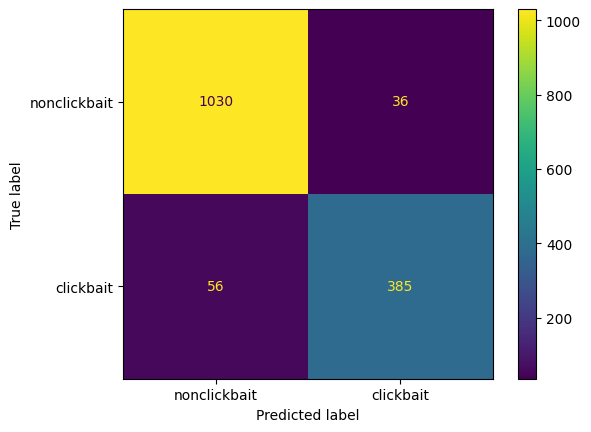

In [28]:
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids

probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
y_pred = (probs >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["nonclickbait", "clickbait"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["nonclickbait","clickbait"])
disp.plot()
plt.show()